GitHub link for the talk. You can clone the data and play with it yourself. Please submit any improvements as pull requests

[https://github.com/jseabold/538model](https://github.com/jseabold/538model)

In [1]:
import datetime

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas
from pandas import DataFrame, Series
from scipy import stats
np.set_printoptions(precision=4, suppress=True)
%matplotlib inline


In [2]:
today = datetime.datetime(2012, 10, 2)

## Outline

Methodology was obtained from the old [538 Blog](http://www.fivethirtyeight.com/2008/03/frequently-asked-questions-last-revised.html) with updates at the [new site hosted by the New York Times](http://fivethirtyeight.blogs.nytimes.com/methodology/)

1. Polling Average: Aggregate polling data, and weight it according to our reliability scores.

2. Trend Adjustment: Adjust the polling data for current trends.

3. Regression: Analyze demographic data in each state by means of regression analysis.

4. Snapshot: Combine the polling data with the regression analysis to produce an electoral snapshot. This is our estimate of what would happen if the election were held today.

5. Projection: Translate the snapshot into a projection of what will happen in November, by allocating out undecided voters and applying a discount to current polling leads based on historical trends.

6. Simulation: Simulate our results 10,000 times based on the results of the projection to account for the uncertainty in our estimates. The end result is a robust probabilistic assessment of what will happen in each state as well as in the nation as a whole. 

## Get the Data

### Consensus forecast of GDP growth over the next two economic quarters <br />(Median of WSJ's monthly forecasting panel)

The process for creating an economic index for the 538 model is described [here](http://fivethirtyeight.blogs.nytimes.com/2012/07/05/measuring-the-effect-of-the-economy-on-elections/#more-31732).

In [3]:
forecasts = pandas.read_csv("data_nuevo/wsj_forecast.csv")

In [4]:
forecasts

,Unnamed: 0,Unnamed: 0.1,Forecaster,Institution,gdp_q3_2012,gdp_q4_2012
0,0,0,Paul Ashworth,Capital Economics,2.0,1.5
1,1,1,Nariman Behravesh,IHS Global Insight,1.5,1.6
2,2,2,Richard Berner/ David Greenlaw *,Morgan Stanley,NaN,NaN
3,3,3,Ram Bhagavatula,Combinatorics Capital,2.0,4.0
4,4,4,Beth Ann Bovino *,Standard and Poor's,NaN,NaN
5,5,5,Jay Brinkmann,Mortgage Bankers Association,1.8,1.9
6,6,6,Michael Carey,Credit Agricole CIB,1.7,1.6
7,7,7,Joseph Carson,AllianceBernstein,2.5,3.5
8,8,8,Julia Coronado,BNP Paribas,1.4,1.6
9,9,9,Mike Cosgrove,Econoclast,1.6,1.6


In [5]:
median_forecast = forecasts[['gdp_q3_2012', 'gdp_q4_2012']].median()

In [6]:
median_forecast

gdp_q3_2012    1.8
gdp_q4_2012    1.8
dtype: float64

### Polling Data

I used Python to scrape the [Real Clear Politics](realclearpolitics.com) website and download data for the 2004 and 2008 elections. The scraping scripts are available in the github repository for this talk. State by state historical data for the 2004 and 2008 Presidential elections was obtained from [electoral-vote.com](www.electorical-vote.com).

## Polling Average

Details can be found at the 538 blog [here](http://www.fivethirtyeight.com/2008/03/pollster-ratings-updated.html).

In [7]:
tossup = ["Colorado", "Florida", "Iowa", "New Hampshire", "Nevada", 
          "Ohio", "Virginia", "Wisconsin"]

In [8]:
national_data2012 = pandas.read_pickle("data_nuevo/2012_poll_data_national.pkl")

In [208]:
national_data2012.shape

(290, 9)

In [9]:
national_data2012.head(5)

,Pollster,Sample,MoE,Obama (D),Romney (R),Spread,obama_spread,State,poll_date
0,RCP Average,NaN,--,49.1,45.1,Obama +4.0,4,USA,2012-09-28
1,Rasmussen Tracking,1500,3.0,48.0,47.0,Obama +1,1,USA,2012-09-30
2,CNN/Opinion Research,783,3.5,50.0,47.0,Obama +3,3,USA,2012-09-29
3,Gallup Tracking,3050,2.0,50.0,44.0,Obama +6,6,USA,2012-09-28
4,Quinnipiac,1912,2.2,49.0,45.0,Obama +4,4,USA,2012-09-28


In [10]:
state_data2012 = pandas.read_pickle("data_nuevo/2012_poll_data_states.pkl")

In [209]:
state_data2012.shape

(357, 19)

In [11]:
state_data2012.head(5)

,Pollster,State,MoE,Obama (D),Romney (R),Sample,Spread,obama_spread,poll_date
0,Rasmussen Reports,WA,4.5,52,41,500,Obama +11,11,2012-09-26
1,Gravis Marketing,WA,4.6,56,39,625,Obama +17,17,2012-09-22
2,Elway Poll,WA,5.0,53,36,405,Obama +17,17,2012-09-11
3,SurveyUSA,WA,4.4,54,38,524,Obama +16,16,2012-09-08
4,SurveyUSA,WA,4.4,54,37,524,Obama +17,17,2012-08-02


In [12]:
pollsters = state_data2012.Pollster.unique()
pollsters.sort()

In [13]:
len(pollsters)

120

In [14]:
print pandas.Series(pollsters)

0                AFP/Magellan (R)
1              AIF/McLaughlin (R)
2                             ARG
3            Albuquerque Journal*
4                   Arizona State
5                   Baltimore Sun
6              Baydoun/Foster (D)
7        Behavior Research Center
8                  Bloomberg News
9                    Boston Globe
10             CBS/NYT/Quinnipiac
11           CNN/Opinion Research
12                       CNN/Time
13             CNU/Times-Dispatch
14     Caddell/McLaughlin/SAN (R)
15        Castleton State College
16                Chicago Tribune
17                    Civitas (R)
18                Clarus Research
19             Columbus Dispatch*
20      Courier-Journal/SurveyUSA
21              Critical Insights
22              Daily Kos/PPP (D)
23                      Dartmouth
24          Denver Post/SurveyUSA
25            Des Moines Register
26                   Deseret News
27               Deseret News/KSL
28                   Detroit News
29            

### 538 Pollster Ratings

In [15]:
weights = pandas.read_table("./data/pollster_weights.csv")

In [16]:
weights

,Pollster,Weight,PIE
0,ABC / Washington Post,0.95,1.41
1,American Research Group,0.65,1.76
2,CBS / New York Times,0.66,1.84
3,Chicago Trib. / MarketShares,1.16,1.13
4,CNN / Opinion Research,0.77,1.59
5,Columbus Dispatch (OH),0.50,6.76
6,EPIC-MRA,0.75,1.65
7,Fairleigh-Dickinson (NJ),0.71,1.72
8,Field Poll (CA),1.33,0.88
9,Fox / Opinion Dynamics,0.79,1.60


In [17]:
weights.mean()

Weight    0.907813
PIE       1.706563
dtype: float64

In [18]:
import pickle
pollster_map = pickle.load(open("./data/pollster_map.pkl", "rb"))

In [19]:
state_data2012.Pollster.replace(pollster_map, inplace=True);

In [20]:
national_data2012.Pollster.replace(pollster_map, inplace=True);

Inner merge the data with the weights

In [21]:
state_data2012 = state_data2012.merge(weights, how="inner", on="Pollster")

In [22]:
state_data2012.head(5)

,Pollster,State,MoE,Obama (D),Romney (R),Sample,Spread,obama_spread,poll_date,Weight,PIE
0,Rasmussen,WA,4.5,52,41,500,Obama +11,11,2012-09-26,1.3,0.88
1,Rasmussen,WI,4.5,49,46,500,Obama +3,3,2012-09-17,1.3,0.88
2,Rasmussen,WI,4.5,47,48,500,Romney +1,-1,2012-08-15,1.3,0.88
3,Rasmussen,WI,4.5,49,46,500,Obama +3,3,2012-07-25,1.3,0.88
4,Rasmussen,WI,4.5,44,47,500,Romney +3,-3,2012-06-12,1.3,0.88


In [23]:
state_data2012.dtypes

Pollster                object
State                   object
MoE                    float64
Obama (D)              float64
Romney (R)             float64
Sample                 float64
Spread                  object
obama_spread           float64
poll_date       datetime64[ns]
Weight                 float64
PIE                    float64
dtype: object

#### First, we average each pollster for each state.

The first adjustment is an exponential decay for recency of the poll. Based on research in prior elections, a weight with a half-life of 30 days since the median date the poll has been in the field is assigned to each poll.

In [24]:
def exp_decay(x):
    # defensive coding, accepts timedeltas
    #days = getattr(days, "days", days)
    days = x.astype('timedelta64[D]')/ np.timedelta64(1, 'D')
    # print("days is", type(days))
    return .5 ** (days/30.)

(0, 45)

//anaconda/envs/pydata/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


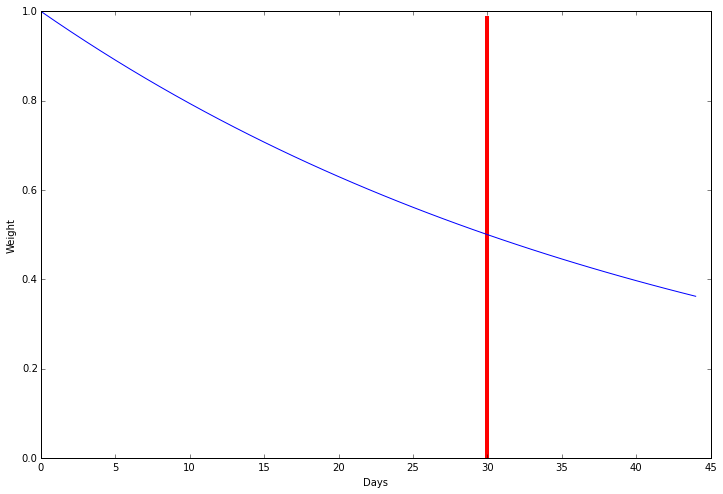

In [25]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={"xlabel" : "Days",
                                                   "ylabel" : "Weight"})
days = np.arange(0, 45)
ax.plot(days, exp_decay(days));
ax.vlines(30, 0, .99, color='r', linewidth=4)
ax.set_ylim(0,1)
ax.set_xlim(0, 45)


The second adjustment is for the sample size of the poll. Polls with a higher sample size receive a higher weight.

Binomial sampling error = +/- $50 * \frac{1}{\sqrt{nobs}}$ where the 50 depends on the underlying probability or population preferences, in this case assumed to be 50:50 (another way of calculating Margin of Error)

In [26]:
def average_error(nobs, p=50.):
    return p*nobs**-.5

The thinking here is that having 5 polls of 1200 is a lot like having one poll of 6000. However, we downweight older polls by only including the marginal effective sample size. Where the effective sample size is the size of the methodologically perfect poll for which we would be indifferent between it and the one we have with our current total error. Total error is determined as $TE = \text{Average Error} + \text{Long Run Pollster Induced Error}$. See [here](http://www.fivethirtyeight.com/2008/04/pollster-ratings-v30.html) for the detailed calculations of Pollster Induced Error.

In [27]:
def effective_sample(total_error, p=50.):
    return p**2 * (total_error**-2.)

In [28]:
state_pollsters = state_data2012.groupby(["State", "Pollster"])

In [29]:
ppp_az = state_pollsters.get_group(("AZ", "Public Policy Polling (PPP)"))

In [30]:
var_idx = ["Pollster", "State", "Obama (D)", "Romney (R)", "Sample", "poll_date"]
ppp_az[var_idx]

,Pollster,State,Obama (D),Romney (R),Sample,poll_date
258,Public Policy Polling (PPP),AZ,44,53,993,2012-09-08
259,Public Policy Polling (PPP),AZ,41,52,833,2012-07-24
260,Public Policy Polling (PPP),AZ,43,50,500,2012-05-19
261,Public Policy Polling (PPP),AZ,47,47,743,2012-02-18
262,Public Policy Polling (PPP),AZ,42,49,500,2011-11-19
263,Public Policy Polling (PPP),AZ,44,48,623,2011-04-30
264,Public Policy Polling (PPP),AZ,43,49,599,2011-01-29
265,Public Policy Polling (PPP),AZ,43,50,617,2010-09-20


In [31]:
ppp_az.sort("poll_date", ascending=False, inplace=True);

//anaconda/envs/pydata/lib/python2.7/site-packages/pandas/core/frame.py:2915: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  inplace=inplace, kind=kind, na_position=na_position)


In [32]:
ppp_az["cumulative"] = ppp_az["Sample"].cumsum()
ppp_az["average_error"] = average_error(ppp_az["cumulative"])
ppp_az["total_error"] = ppp_az["PIE"] + ppp_az["average_error"]
ppp_az[var_idx + ["cumulative"]]

/anaconda/envs/pydata/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda/envs/pydata/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/envs/pydata/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

,Pollster,State,Obama (D),Romney (R),Sample,poll_date,cumulative
258,Public Policy Polling (PPP),AZ,44,53,993,2012-09-08,993
259,Public Policy Polling (PPP),AZ,41,52,833,2012-07-24,1826
260,Public Policy Polling (PPP),AZ,43,50,500,2012-05-19,2326
261,Public Policy Polling (PPP),AZ,47,47,743,2012-02-18,3069
262,Public Policy Polling (PPP),AZ,42,49,500,2011-11-19,3569
263,Public Policy Polling (PPP),AZ,44,48,623,2011-04-30,4192
264,Public Policy Polling (PPP),AZ,43,49,599,2011-01-29,4791
265,Public Policy Polling (PPP),AZ,43,50,617,2010-09-20,5408


In [33]:
ppp_az["ESS"] = effective_sample(ppp_az["total_error"])
ppp_az["MESS"] = ppp_az["ESS"].diff()
# fill in first one
ppp_az["MESS"].fillna(ppp_az["ESS"].head(1).item(), inplace=True);

/anaconda/envs/pydata/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda/envs/pydata/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
//anaconda/envs/pydata/lib/python2.7/site-packages/pandas/core/generic.py:2602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.py

In [34]:
ppp_az[["poll_date", "Sample", "cumulative", "ESS", "MESS"]]

,poll_date,Sample,cumulative,ESS,MESS
258,2012-09-08,993,993,246.182451,246.182451
259,2012-07-24,833,1826,325.800656,79.618204
260,2012-05-19,500,2326,359.591232,33.790577
261,2012-02-18,743,3069,399.185055,39.593822
262,2011-11-19,500,3569,420.967611,21.782557
263,2011-04-30,623,4192,444.240505,23.272893
264,2011-01-29,599,4791,463.531139,19.290634
265,2010-09-20,617,5408,480.955020,17.423881


Now let's do it for every polling firm in every state.

In [35]:
def calculate_mess(group):
    cumulative = group["Sample"].cumsum()
    ae = average_error(cumulative)
    total_error = ae + group["PIE"]
    ess = effective_sample(total_error)
    mess = ess.diff()
    mess.fillna(ess.head(1).item(), inplace=True)
    #from IPython.core.debugger import Pdb; Pdb().set_trace()
    return pandas.concat((ess, mess), axis=1)

#state_data2012["ESS", "MESS"] 
df = state_pollsters.apply(calculate_mess)
df.rename(columns={0 : "ESS", 1 : "MESS"}, inplace=True);

In [36]:
state_data2012 = state_data2012.join(df)

Give them the time weight

In [37]:
state_data2012["poll_date"].head(1)

0   2012-09-26
Name: poll_date, dtype: datetime64[ns]

In [38]:
state_data2012["time_weight"] = (today - state_data2012["poll_date"]).apply(exp_decay)

In [39]:
state_data2012["time_weight"]

0      0.870551
1      0.707107
2      0.329877
3      0.203063
4      0.075189
5      0.034276
6      0.012691
7      0.006494
8      0.000370
9      0.629961
10     0.329877
11     0.140308
12     0.024803
13     0.009184
14     0.004284
15     0.000615
16     0.723635
17     0.090454
18     0.050766
19     0.890899
20     0.378929
21     0.014919
22     0.004809
23     0.644685
24     0.238710
25     0.101532
26     0.038473
27     0.017538
28     0.146943
29     0.040293
         ...   
393    0.017948
394    0.002637
395    0.000370
396    0.629961
397    0.106333
398    0.049606
399    0.004385
400    0.000675
401    0.000119
402    0.723635
403    0.198425
404    0.046284
405    0.831238
406    0.370274
407    0.361817
408    0.000147
409    0.003817
410    0.601513
411    0.445449
412    0.217638
413    0.062500
414    0.014579
415    0.002893
416    0.000587
417    0.000031
418    0.000001
419    0.396850
420    0.314980
421    0.193893
422    0.086370
Name: time_weight, dtype

Now aggregate all of these. Weight them based on the sample size but also based on the time_weight.

In [40]:
def weighted_mean(group):
    weights1 = group["time_weight"]
    weights2 = group["MESS"]
    return np.sum(weights1*weights2*group["obama_spread"]/(weights1*weights2).sum())

In [41]:
state_pollsters = state_data2012.groupby(["State", "Pollster"])
state_polls = state_pollsters.apply(weighted_mean)

In [42]:
state_polls

State  Pollster                    
AZ     Public Policy Polling (PPP)     -9.168494
       Rasmussen                      -10.209446
CA     Field Poll (CA)                 23.343924
       Public Policy Polling (PPP)     20.999075
       Rasmussen                       22.000000
       SurveyUSA                       22.123414
CO     American Research Group          2.000000
       Public Policy Polling (PPP)      5.469907
       Rasmussen                       -1.573788
CT     Public Policy Polling (PPP)     12.757757
       Quinnipiac                       7.293983
       Rasmussen                        8.000000
FL     American Research Group          5.000000
       Mason-Dixon                     -3.543178
       Public Policy Polling (PPP)      3.125154
       Quinnipiac                       3.075653
       Rasmussen                        0.882884
       Suffolk (NH/MA)                 -0.003377
       SurveyUSA                        4.168952
GA     Insider Advantage         

### 2004 and 2008 Polls

In [43]:
state_data2008= pandas.read_pickle("data_nuevo/state_data_2008.pkl"); state_data2004 = pandas.read_pickle("data_nuevo/state_data_2004.pkl")

In [46]:
state_data2004.head(5)

,State,Kerry,Bush,Pollster,poll_date
0,AL,39,57,SurveyUSA,2004-10-25
1,AL,32,56,Capital Survey,2004-10-12
2,AL,34,62,SurveyUSA,2004-10-01
3,AL,40,54,ARG,2004-09-14
4,AL,42,53,Rasmussen,2004-09-06


In [47]:
state_data2008.head(5)

,State,Obama,McCain,Pollster,poll_date
0,AL,36,61,SurveyUSA,2008-10-28
1,AL,34,54,Capital Survey,2008-10-16
2,AL,35,62,SurveyUSA,2008-10-09
3,AL,35,55,Capital Survey,2008-10-07
4,AL,39,60,Rasmussen,2008-09-22


In [48]:
state_groups = state_data2008.groupby("State")

In [49]:
state_groups.aggregate(dict(Obama=np.mean, McCain=np.mean))

,McCain,Obama
State,,
AK,52.000000,39.428571
AL,56.826087,34.347826
AR,51.000000,37.250000
AZ,49.333333,39.190476
CA,37.633333,53.266667
CO,44.466667,48.288889
CT,36.923077,52.692308
DC,13.000000,82.000000
DE,38.625000,55.500000


Means for the entire country (without weighting by population)

In [50]:
state_groups.aggregate(dict(Obama=np.mean, McCain=np.mean)).mean()

McCain    45.337861
Obama     46.082498
dtype: float64

In [197]:
pollster_map

{'ARG': 'American Research Group',
 'American Res.Group': 'American Research Group',
 'American Research': 'American Research Group',
 'Bloomberg News': 'LA Times / Bloomberg',
 'CNN/Opinion Research': 'CNN / Opinion Research',
 'Chicago Tribune': 'Chicago Trib. / MarketShares',
 'Columbus Dispatch': 'Columbus Dispatch (OH)',
 'Columbus Dispatch*': 'Columbus Dispatch (OH)',
 'EPIC/MRA': 'EPIC-MRA',
 'Fairleigh Dickinson': 'Fairleigh-Dickinson (NJ)',
 'Fairleigh Dickinson U.': 'Fairleigh-Dickinson (NJ)',
 'Fairleigh Dickinson Univ.': 'Fairleigh-Dickinson (NJ)',
 'Fairleigh-Dickinson Univ.': 'Fairleigh-Dickinson (NJ)',
 'Field': 'Field Poll (CA)',
 'Field Poll': 'Field Poll (CA)',
 'Fox/Opinion Dyn.': 'Fox / Opinion Dynamics',
 'Franklin Pierce Coll.': 'Franklin Pierce (NH)',
 'Gallup': 'USA Today / Gallup',
 'Inside Advantage': 'Insider Advantage',
 'InsiderAdvantage': 'Insider Advantage',
 'Keystone Poll': 'Keystone (PA)',
 'LA Times': 'LA Times / Bloomberg',
 'Los Angeles Times': 'LA 

In [51]:
state_data2004.Pollster.replace(pollster_map, inplace=True)
state_data2008.Pollster.replace(pollster_map, inplace=True);

In [52]:
state_data2004 = state_data2004.merge(weights, how="inner", on="Pollster")
state_data2008 = state_data2008.merge(weights, how="inner", on="Pollster")

In [198]:
state_data2004.head() ## Weight and PIE added in by previous step

,State,Kerry,Bush,Pollster,poll_date,Weight,PIE,time_weight,newest_poll
0,AL,39,57,SurveyUSA,2004-10-25,1.91,0.72,0.831238,1970-01-01 00:00:00.000000001
1,AZ,41,56,SurveyUSA,2004-10-28,1.91,0.72,0.890899,1970-01-01 00:00:00.000000001
2,AZ,43,54,SurveyUSA,2004-10-17,1.91,0.72,0.690956,1970-01-01 00:00:00.000000000
3,AR,46,51,SurveyUSA,2004-11-01,1.91,0.72,0.977160,1970-01-01 00:00:00.000000001
4,AR,45,51,SurveyUSA,2004-10-23,1.91,0.72,0.793701,1970-01-01 00:00:00.000000000


In [53]:
len(state_data2004.Pollster.unique())

26

In [54]:
len(state_data2008.Pollster.unique())

21

In [55]:
date2004 = datetime.datetime(2004, 11, 2)
date2004

datetime.datetime(2004, 11, 2, 0, 0)

In [56]:
(date2004 - state_data2004.poll_date) < datetime.timedelta(21) ## Restrict to 3 weeks before the election

0       True
1      False
2      False
3       True
4       True
5      False
6      False
7      False
8       True
9       True
10      True
11     False
12     False
13     False
14      True
15      True
16     False
17     False
18     False
19     False
20      True
21      True
22      True
23     False
24     False
25     False
26      True
27      True
28      True
29     False
       ...  
704     True
705     True
706     True
707     True
708     True
709     True
710    False
711    False
712    False
713     True
714    False
715     True
716     True
717    False
718     True
719     True
720    False
721     True
722     True
723    False
724    False
725    False
726    False
727    False
728     True
729    False
730     True
731    False
732     True
733     True
Name: poll_date, dtype: bool

Restrict the samples to the 3 weeks leading up to the election

In [57]:
state_data2004 = state_data2004.ix[(date2004 - state_data2004.poll_date) <= datetime.timedelta(21)]
state_data2004.reset_index(drop=True, inplace=True)

In [58]:
date2008 = datetime.datetime(2008, 11, 4)

In [59]:
state_data2008 = state_data2008.ix[(date2008 - state_data2008.poll_date) <= datetime.timedelta(21)]
state_data2008.reset_index(drop=True, inplace=True)

In [60]:
state_data2008.dtypes

State                object
Obama                 int64
McCain                int64
Pollster             object
poll_date    datetime64[ns]
Weight              float64
PIE                 float64
dtype: object

In [ ]:
## Add time weight to each poll that we have in the filtered 3 week set using the exp_decay function defined earlier

In [61]:
state_data2004["time_weight"] =(date2004 - state_data2004.poll_date).apply(exp_decay)
state_data2008["time_weight"] =(date2008 - state_data2008.poll_date).apply(exp_decay)

In [62]:
state_data2004[["time_weight", "poll_date"]].head(5)

,time_weight,poll_date
0,0.831238,2004-10-25
1,0.890899,2004-10-28
2,0.690956,2004-10-17
3,0.977160,2004-11-01
4,0.793701,2004-10-23


In [63]:
def max_date(x):
    return x == x.max()

In [ ]:
## Assign the latest poll date to all polls for each (state,pollster) group. Why?

In [64]:
state_data2004["newest_poll"] = state_data2004.groupby(("State", "Pollster")).poll_date.transform(max_date)
state_data2008["newest_poll"] = state_data2008.groupby(("State", "Pollster")).poll_date.transform(max_date)

### Clustering States by Demographics

There are notes on trend line adjustment, [here](http://www.fivethirtyeight.com/2008/06/we-know-more-than-we-think-big-change-2.html), [here](http://www.fivethirtyeight.com/2008/06/refinement-to-adjustment-part-i.html), [here](http://www.fivethirtyeight.com/2008/06/refinement-to-adjustment-part-ii.html), [here](http://www.fivethirtyeight.com/2008/06/trendline-now-calculated-from-daily.html), and [here](http://www.fivethirtyeight.com/2008/06/construction-season-over-technical.html). However, to the best of my knowledge, the similar state "nearest neighbor" clustering remains a black box.

Partican Voting Index data obtained from [Wikipedia](http://en.wikipedia.org/wiki/Cook_Partisan_Voting_Index)

In [65]:
pvi = pandas.read_csv("./data/partisan_voting.csv") 


In [66]:
pvi.set_index("State", inplace=True);
pvi

,PVI
State,
Alabama,R+13
Alaska,R+13
Arizona,R+6
Arkansas,R+9
California,D+7
Colorado,EVEN
Connecticut,D+7
Delaware,D+7
District of Columbia,D+39


In [67]:
pvi.PVI = pvi.PVI.replace({"EVEN" : "0"})
pvi.PVI = pvi.PVI.str.replace("R\+", "-")
pvi.PVI = pvi.PVI.str.replace("D\+", "")
pvi.PVI = pvi.PVI.astype(float)
pvi.PVI

State
Alabama                -13
Alaska                 -13
Arizona                 -6
Arkansas                -9
California               7
Colorado                 0
Connecticut              7
Delaware                 7
District of Columbia    39
Florida                 -2
Georgia                 -7
Hawaii                  12
Idaho                  -17
Illinois                 8
Indiana                 -6
Iowa                     1
Kansas                 -12
Kentucky               -10
Louisiana              -10
Maine                    5
Maryland                 9
Massachusetts           12
Michigan                 4
Minnesota                2
Mississippi            -10
Missouri                -3
Montana                 -7
Nebraska               -13
Nevada                   1
New Hampshire            2
New Jersey               4
New Mexico               2
New York                10
North Carolina          -4
North Dakota           -10
Ohio                    -1
Oklahoma              

Party affliation of electorate obtained from [Gallup](http://www.gallup.com/poll/156437/Heavily-Democratic-States-Concentrated-East.aspx#2).

In [68]:
party_affil = pandas.read_csv("./data/gallup_electorate.csv")

In [69]:
party_affil.Democrat = party_affil.Democrat.str.replace("%", "").astype(float)
party_affil.Republican = party_affil.Republican.str.replace("%", "").astype(float)
party_affil.set_index("State", inplace=True);
party_affil.rename(columns={"Democrat Advantage" : "dem_adv"}, inplace=True);
party_affil["no_party"] = 100 - party_affil.Democrat - party_affil.Republican

In [70]:
party_affil

,Democrat,Republican,dem_adv,N,no_party
State,,,,,
District of Columbia,79.0,12.7,66.3000,416,8.3
Rhode Island,52.5,26.5,26.0000,623,21.0
Hawaii,54.3,28.7,25.6000,466,17.0
New York,52.0,30.8,21.2000,8674,17.2
Maryland,54.0,33.8,20.2000,3571,12.2
Massachusetts,52.5,33.4,19.1000,3583,14.1
Delaware,50.5,33.1,17.4000,540,16.4
Connecticut,49.8,34.4,15.4000,2020,15.8
Vermont,48.8,34.9,13.9000,550,16.3


In [71]:
census_data = pandas.read_csv("./data/census_demographics.csv")

In [72]:
def capitalize(s):
    s = s.title()
    s = s.replace("Of", "of")
    return s

In [73]:
census_data["State"] = census_data.state.map(capitalize)
del census_data["state"]

In [199]:
census_data.head()

,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote
State,,,,,,,,,,,,
Alabama,26.5,4.0,66.8,81.4,21.7,22984,42081,94.4,3001712.500,672383.600,0.140,0.625
Alaska,3.6,5.8,63.7,90.7,27.0,30726,66521,1.2,475548.444,58540.158,0.081,0.658
Arizona,4.5,30.1,57.4,85.0,26.3,25680,50448,56.3,3934880.535,920515.710,0.142,0.607
Arkansas,15.6,6.6,74.2,81.9,19.1,21274,39267,56.0,1798043.148,428944.934,0.146,0.612
California,6.6,38.1,39.7,80.7,30.1,29188,60883,239.1,24009747.944,4409953.704,0.117,0.637


In [74]:
census_data.set_index("State", inplace=True)

In [75]:
states_abbrev_dict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

Campaign Contributions from FEC.

In [76]:
obama_give = pandas.read_csv("./data/obama_indiv_state.csv", 
                             header=None, names=["State", "obama_give"])
romney_give = pandas.read_csv("./data/romney_indiv_state.csv",
                             header=None, names=["State", "romney_give"])

In [77]:
obama_give.State.replace(states_abbrev_dict, inplace=True);
romney_give.State.replace(states_abbrev_dict, inplace=True);

In [78]:
obama_give.set_index("State", inplace=True)
romney_give.set_index("State", inplace=True);

In [79]:
demo_data = census_data.join(party_affil[["dem_adv", "no_party"]]).join(pvi)

In [80]:
demo_data = demo_data.join(obama_give).join(romney_give)

In [203]:
giving = demo_data[["obama_give", "romney_give"]].div(demo_data[["vote_pop", "older_pop"]].sum(1), axis=0)
giving.head()

,obama_give,romney_give
0,6.658811e-08,9.952707e-08
1,2.081808e-06,9.336994e-07
2,1.171138e-07,1.385368e-07
3,1.108137e-07,9.728485e-08
4,3.969586e-08,2.173072e-08


In [82]:
demo_data[["obama_give", "romney_give"]] = giving

In [83]:
from scipy import cluster as sp_cluster
from sklearn import cluster, neighbors

In [84]:
clean_data = sp_cluster.vq.whiten(demo_data.values)

In [85]:
clean_data.var(axis=0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.])

In [86]:
KNN = neighbors.NearestNeighbors(n_neighbors=7)
KNN.fit(clean_data)
KNN.kneighbors(clean_data[0], return_distance=True)

//anaconda/envs/pydata/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


(array([[ 0.    ,  0.895 ,  1.4131,  1.4377,  2.0061,  2.1917,  2.3806]]),
 array([[ 0, 40, 18, 42, 24, 33, 17]]))

In [87]:
idx = _[1]
demo_data.index[0], demo_data.index[idx]

('Alabama',
 Index([[u'Alabama', u'South Carolina', u'Louisiana', u'Tennessee', u'Mississippi', u'North Carolina', u'Kentucky']], dtype='object', name=u'State'))

In [88]:
nearest_neighbor = {}
for i, state in enumerate(demo_data.index):
    neighborhood = KNN.kneighbors(clean_data[i], return_distance=True)
    nearest_neighbor.update({state : (demo_data.index[neighborhood[1]],
                                     neighborhood[0])})

//anaconda/envs/pydata/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
//anaconda/envs/pydata/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
//anaconda/envs/pydata/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

In [89]:
nearest_neighbor

{'Alabama': (Index([[u'Alabama', u'South Carolina', u'Louisiana', u'Tennessee', u'Mississippi', u'North Carolina', u'Kentucky']], dtype='object', name=u'State'),
  array([[ 0.    ,  0.895 ,  1.4131,  1.4377,  2.0061,  2.1917,  2.3806]])),
 'Alaska': (Index([[u'Alaska', u'Colorado', u'Wyoming', u'Washington', u'Virginia', u'Nevada', u'New Hampshire']], dtype='object', name=u'State'),
  array([[ 0.    ,  4.3342,  4.5308,  4.7701,  4.9261,  4.9871,  5.2991]])),
 'Arizona': (Index([[u'Arizona', u'Oklahoma', u'New Mexico', u'Kansas', u'Nevada', u'North Carolina', u'Oregon']], dtype='object', name=u'State'),
  array([[ 0.    ,  2.9343,  2.9355,  3.1193,  3.1995,  3.3985,  3.4008]])),
 'Arkansas': (Index([[u'Arkansas', u'Tennessee', u'Alabama', u'Missouri', u'Indiana', u'Kentucky', u'South Carolina']], dtype='object', name=u'State'),
  array([[ 0.    ,  2.2112,  2.4606,  2.612 ,  2.6739,  2.7217,  2.7387]])),
 'California': (Index([[u'California', u'Texas', u'New York', u'Illinois', u'Florida

In [90]:
k_means = cluster.KMeans(n_clusters=5, n_init=50)
k_means.fit(clean_data)
values = k_means.cluster_centers_.squeeze()
labels = k_means.labels_

In [91]:
clusters = sp_cluster.vq.kmeans(clean_data, 5)[0]

In [92]:
def choose_group(data, clusters):
    """
    Return the index of the cluster to which the rows in data
    are "closest" (in the sense of the L2-norm)
    """
    data = data[:,None] # add an axis for broadcasting
    distances = data - clusters
    groups = []
    for row in distances:
        dists = map(np.linalg.norm, row)
        groups.append(np.argmin(dists))
    return groups

In [93]:
groups = choose_group(clean_data, clusters)

In [94]:
np.array(groups)

array([0, 4, 1, 0, 1, 2, 2, 2, 3, 1, 0, 2, 4, 2, 0, 4, 4, 0, 0, 4, 2, 2, 0,
       4, 0, 0, 4, 4, 1, 4, 2, 1, 2, 0, 4, 0, 0, 4, 0, 2, 0, 4, 0, 1, 4, 4,
       2, 2, 0, 4, 4])

Or use a one-liner

In [95]:
groups = [np.argmin(map(np.linalg.norm, (clean_data[:,None] - clusters)[i])) for i in range(51)]

In [96]:
demo_data["kmeans_group"] = groups
demo_data["kmeans_labels"] = labels

In [97]:
for _, group in demo_data.groupby("kmeans_group"):
    group = group.index
    group.values.sort()
    print group.values

['Alabama' 'Arkansas' 'Georgia' 'Indiana' 'Kentucky' 'Louisiana' 'Michigan'
 'Mississippi' 'Missouri' 'North Carolina' 'Ohio' 'Oklahoma' 'Pennsylvania'
 'South Carolina' 'Tennessee' 'West Virginia']
['Arizona' 'California' 'Florida' 'Nevada' 'New Mexico' 'Texas']
['Colorado' 'Connecticut' 'Delaware' 'Hawaii' 'Illinois' 'Maryland'
 'Massachusetts' 'New Jersey' 'New York' 'Rhode Island' 'Virginia'
 'Washington']
['District of Columbia']
['Alaska' 'Idaho' 'Iowa' 'Kansas' 'Maine' 'Minnesota' 'Montana' 'Nebraska'
 'New Hampshire' 'North Dakota' 'Oregon' 'South Dakota' 'Utah' 'Vermont'
 'Wisconsin' 'Wyoming']


In [98]:
labels

array([1, 0, 3, 1, 4, 0, 0, 0, 2, 4, 1, 0, 3, 0, 3, 3, 3, 1, 1, 3, 0, 0, 3,
       0, 1, 3, 3, 3, 0, 0, 0, 3, 4, 1, 3, 3, 3, 3, 3, 0, 1, 3, 1, 4, 3, 0,
       0, 0, 1, 3, 3], dtype=int32)

In [99]:
demo_data["kmeans_labels"] = labels
for _, group in demo_data.groupby("kmeans_labels"):
    group = group.index.copy()
    group.values.sort()
    print group.values

['Alaska' 'Colorado' 'Connecticut' 'Delaware' 'Hawaii' 'Illinois'
 'Maryland' 'Massachusetts' 'Minnesota' 'Nevada' 'New Hampshire'
 'New Jersey' 'Rhode Island' 'Vermont' 'Virginia' 'Washington']
['Alabama' 'Arkansas' 'Georgia' 'Kentucky' 'Louisiana' 'Mississippi'
 'North Carolina' 'South Carolina' 'Tennessee' 'West Virginia']
['District of Columbia']
['Arizona' 'Idaho' 'Indiana' 'Iowa' 'Kansas' 'Maine' 'Michigan' 'Missouri'
 'Montana' 'Nebraska' 'New Mexico' 'North Dakota' 'Ohio' 'Oklahoma'
 'Oregon' 'Pennsylvania' 'South Dakota' 'Utah' 'Wisconsin' 'Wyoming']
['California' 'Florida' 'New York' 'Texas']


In [100]:
demo_data = demo_data.reset_index()

In [101]:
state_data2012.State.replace(states_abbrev_dict, inplace=True);

In [102]:
state_data2012 = state_data2012.merge(demo_data[["State", "kmeans_labels"]], on="State")

In [103]:
kmeans_groups = state_data2012.groupby("kmeans_labels")

In [104]:
group = kmeans_groups.get_group(kmeans_groups.groups.keys()[2])

In [105]:
group.State.unique()

array(['Wisconsin', 'New Mexico', 'North Dakota', 'Nebraska', 'Ohio',
       'Pennsylvania', 'Indiana', 'Iowa', 'Arizona', 'Maine', 'Missouri',
       'Michigan', 'Montana', 'Kansas', 'Oregon', 'South Dakota', 'Utah'], dtype=object)

In [106]:
def edit_tick_label(tick_val, tick_pos):
    if tick_val  < 0:
        text = str(int(tick_val)).replace("-", "Romney+")
    else:
        text = "Obama+"+str(int(tick_val))
    return text

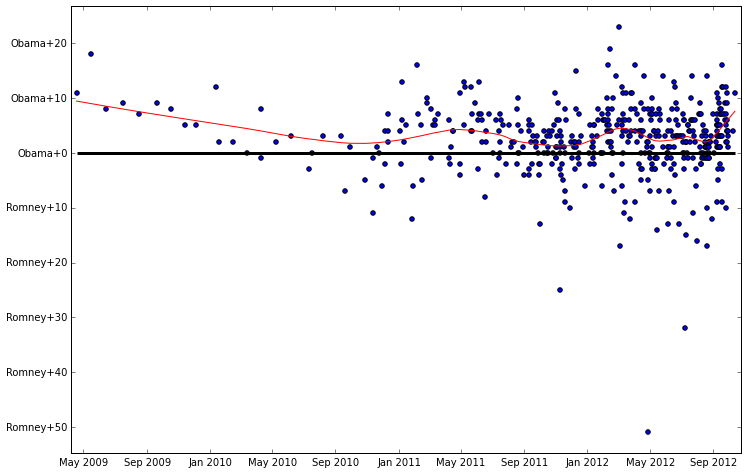

In [107]:
from pandas import lib
from matplotlib.ticker import FuncFormatter
fig, axes = plt.subplots(figsize=(12,8))

data = group[["poll_date", "obama_spread"]]
data = pandas.concat((data, national_data2012[["poll_date", "obama_spread"]]))
    
data.sort("poll_date", inplace=True)
dates = pandas.DatetimeIndex(data.poll_date).asi8

loess_res = sm.nonparametric.lowess(data.obama_spread.values, dates, 
                                    frac=.2, it=3)

dates_x = pandas.to_datetime(dates)
axes.scatter(dates_x, data["obama_spread"])
axes.plot(dates_x, loess_res[:,1], color='r')
axes.yaxis.get_major_locator().set_params(nbins=12)
axes.yaxis.set_major_formatter(FuncFormatter(edit_tick_label))
axes.grid(False, axis='x')
axes.hlines(0, dates_x[0], dates_x[-1], color='black', lw=3)
axes.margins(0, .05)

In [108]:
loess_res[-7:,1].mean()

6.3911808457264527

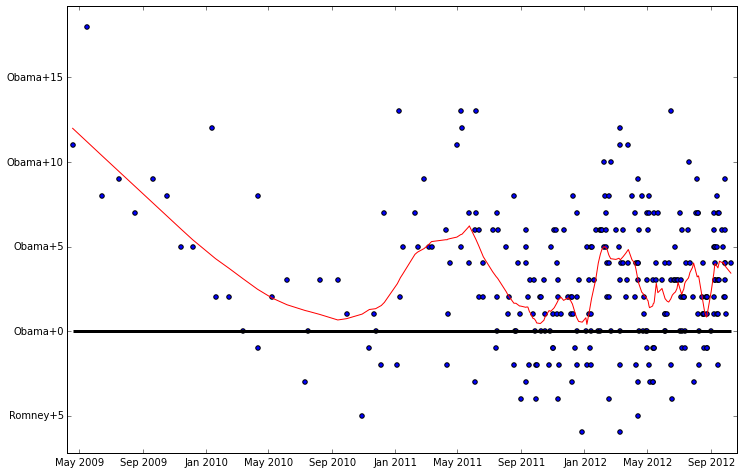

In [109]:
from pandas import lib
from matplotlib.ticker import FuncFormatter
fig, axes = plt.subplots(figsize=(12,8))

national_data2012.sort("poll_date", inplace=True)
dates = pandas.DatetimeIndex(national_data2012.poll_date).asi8

loess_res = sm.nonparametric.lowess(national_data2012.obama_spread.values, dates, 
                                    frac=.075, it=3)

dates_x = pandas.to_datetime(dates)
axes.scatter(dates_x, national_data2012["obama_spread"])
axes.plot(dates_x, loess_res[:,1], color='r')
axes.yaxis.get_major_locator().set_params(nbins=12)
axes.yaxis.set_major_formatter(FuncFormatter(edit_tick_label))
axes.grid(False, axis='x')
axes.hlines(0, dates_x[0], dates_x[-1], color='black', lw=3)
axes.margins(0, .05)

In [110]:
trends = []
for i, group in kmeans_groups:
    data = group[["poll_date", "obama_spread"]]
    data = pandas.concat((data, national_data2012[["poll_date", "obama_spread"]]))
    
    data.sort("poll_date", inplace=True)
    dates = pandas.DatetimeIndex(data.poll_date).asi8

    loess_res = sm.nonparametric.lowess(data.obama_spread.values, dates, 
                                    frac=.1, it=3)
    states = group.State.unique()
    for state in states:
        trends.append([state, loess_res[-7:,1].mean()])

In [111]:
trends

[['Washington', 4.5126101123209397],
 ['New Hampshire', 4.5126101123209397],
 ['New Jersey', 4.5126101123209397],
 ['Nevada', 4.5126101123209397],
 ['Colorado', 4.5126101123209397],
 ['Connecticut', 4.5126101123209397],
 ['Virginia', 4.5126101123209397],
 ['Massachusetts', 4.5126101123209397],
 ['Rhode Island', 4.5126101123209397],
 ['Hawaii', 4.5126101123209397],
 ['Vermont', 4.5126101123209397],
 ['Maryland', 4.5126101123209397],
 ['Minnesota', 4.5126101123209397],
 ['Illinois', 4.5126101123209397],
 ['North Carolina', 2.990114760057434],
 ['Georgia', 2.990114760057434],
 ['West Virginia', 2.990114760057434],
 ['South Carolina', 2.990114760057434],
 ['Tennessee', 2.990114760057434],
 ['Mississippi', 2.990114760057434],
 ['Wisconsin', 5.689142600619455],
 ['New Mexico', 5.689142600619455],
 ['North Dakota', 5.689142600619455],
 ['Nebraska', 5.689142600619455],
 ['Ohio', 5.689142600619455],
 ['Pennsylvania', 5.689142600619455],
 ['Indiana', 5.689142600619455],
 ['Iowa', 5.6891426006194

#### Adjust for sensitivity to time-trends

$$\text{Margin}=X_i+Z_t+\epsilon$$

where $S_i$ are Pollster:State dummies. In a state with a time-dependent trend, you might write

$$\text{Margin}=X_i+m*Z_t$$

where $m$ is a multiplier representing uncertainty in the time-trend parameter. Solving for $m$ gives

$$m=\text{Margin}-\frac{X_i}{Z_t}$$

In [112]:
from statsmodels.formula.api import ols, wls

In [113]:
#pollster_state_dummy = state_data2012.groupby(["Pollster", "State"])["obama_spread"].mean()
#daily_dummy = state_data2012.groupby(["poll_date"])["obama_spread"].mean()

In [114]:
state_data2012["pollster_state"] = state_data2012["Pollster"] + "-" + state_data2012["State"]

There's actually a bug in pandas when you merge on datetimes. In order to avoid it, we need to sort our data now and once again after we merge on dates.

In [115]:
state_data2012.sort(columns=["pollster_state", "poll_date"], inplace=True);

In [116]:
dummy_model = ols("obama_spread ~ C(pollster_state) + C(poll_date)", data=state_data2012).fit()

The base case is American Research Group-Colorado

In [117]:
state_data2012.irow(0)

Pollster                   American Research Group
State                                     Colorado
MoE                                              4
Obama (D)                                       49
Romney (R)                                      47
Sample                                         600
Spread                                    Obama +2
obama_spread                                     2
poll_date                      2012-09-11 00:00:00
Weight                                        0.65
PIE                                           1.76
ESS                                       173.0171
MESS                                      173.0171
time_weight                              0.6155722
kmeans_labels                                    0
pollster_state    American Research Group-Colorado
Name: 168, dtype: object

In [118]:
pollster_state = state_data2012["pollster_state"].unique()
pollster_state.sort()
pollster_state_params = dummy_model.params[1:len(pollster_state)] + dummy_model.params[0]
intercept = dummy_model.params[0]
X = pandas.DataFrame(zip(pollster_state, np.r_[intercept, pollster_state_params]), 
                     columns=["pollster_state", "X"])

In [119]:
dates = state_data2012.poll_date.unique()
dates.sort()
dates_params = intercept + dummy_model.params[-len(dates):]
Z = pandas.DataFrame(zip(dates, dates_params), columns=["poll_date", "Z"])

Drop the ones less than 1.

In [120]:
Z = Z.ix[np.abs(Z.Z) > 1]

In [121]:
state_data2012 = state_data2012.merge(X, on="pollster_state", sort=False)
state_data2012 = state_data2012.merge(Z, on="poll_date", sort=False)

In [122]:
state_data2012.sort(columns=["pollster_state", "poll_date"], inplace=True);

In [123]:
state_data2012["m"] = state_data2012["obama_spread"].sub(state_data2012["X"].div(state_data2012["Z"]))

In [124]:
#m_dataframe.ix[m_dataframe.pollster_state == "American Research Group-New Hampshire"].values

In [125]:
m_dataframe = state_data2012[["State", "m", "poll_date", "Pollster", "pollster_state"]]

In [126]:
m_dataframe["m"].describe()

count    357.000000
mean       3.364920
std        9.414260
min      -52.000000
25%       -0.807689
50%        2.696995
75%        8.172477
max       44.255926
Name: m, dtype: float64

In [127]:
m_size = m_dataframe.groupby("pollster_state").size()

In [128]:
m_size

pollster_state
American Research Group-Colorado           1
American Research Group-Florida            1
American Research Group-Iowa               1
American Research Group-Nevada             1
American Research Group-New Hampshire      3
American Research Group-North Carolina     1
American Research Group-Ohio               1
American Research Group-Virginia           1
CNN / Opinion Research-Wisconsin           1
Chicago Trib. / MarketShares-Illinois      1
Columbus Dispatch (OH)-Ohio                2
EPIC-MRA-Michigan                          8
Fairleigh-Dickinson (NJ)-New Jersey        3
Field Poll (CA)-California                 6
Insider Advantage-Georgia                  2
LA Times / Bloomberg-New Hampshire         1
Marist (NY)-New York                       3
Mason-Dixon-Florida                        3
Mason-Dixon-Georgia                        1
Mason-Dixon-New Hampshire                  1
Mason-Dixon-North Dakota                   1
Mason-Dixon-Utah                        

In [129]:
drop_idx = m_size.ix[m_size == 1]

In [130]:
m_dataframe = m_dataframe.set_index(["pollster_state", "poll_date"])

In [131]:
m_dataframe.xs("American Research Group-New Hampshire", level=0)

,State,m,Pollster
poll_date,,,
2012-03-17,New Hampshire,6.436534,American Research Group
2012-06-23,New Hampshire,0.071010,American Research Group
2012-09-26,New Hampshire,4.054884,American Research Group


In [132]:
m_dataframe = m_dataframe.drop(drop_idx.index, level=0).reset_index()

In [204]:
m_dataframe.head(10)

,pollster_state,poll_date,State,m,Pollster
0,American Research Group-New Hampshire,2012-03-17,New Hampshire,6.436534,American Research Group
1,American Research Group-New Hampshire,2012-06-23,New Hampshire,0.071010,American Research Group
2,American Research Group-New Hampshire,2012-09-26,New Hampshire,4.054884,American Research Group
3,Columbus Dispatch (OH)-Ohio,2012-08-20,Ohio,1.875520,Columbus Dispatch (OH)
4,Columbus Dispatch (OH)-Ohio,2012-09-24,Ohio,7.679307,Columbus Dispatch (OH)
5,EPIC-MRA-Michigan,2011-02-15,Michigan,-4.201071,EPIC-MRA
6,EPIC-MRA-Michigan,2011-07-10,Michigan,-3.096961,EPIC-MRA
7,EPIC-MRA-Michigan,2011-11-15,Michigan,-4.201071,EPIC-MRA
8,EPIC-MRA-Michigan,2012-01-23,Michigan,6.398112,EPIC-MRA
9,EPIC-MRA-Michigan,2012-04-02,Michigan,-0.219418,EPIC-MRA


In [134]:
m_regression_data = m_dataframe.merge(demo_data, on="State")

In [205]:
m_regression_data.head(10)

,pollster_state,poll_date,State,m,Pollster,per_black,per_hisp,per_white,educ_hs,educ_coll,...,older_pop,per_older,per_vote,dem_adv,no_party,PVI,obama_give,romney_give,kmeans_group,kmeans_labels
0,American Research Group-New Hampshire,2012-03-17,New Hampshire,6.436534,American Research Group,1.3,2.9,92.2,90.9,32.9,...,184547.160,0.140,0.648,-1.5,13.9,2,0.961563,0.733997,4,0
1,American Research Group-New Hampshire,2012-06-23,New Hampshire,0.071010,American Research Group,1.3,2.9,92.2,90.9,32.9,...,184547.160,0.140,0.648,-1.5,13.9,2,0.961563,0.733997,4,0
2,American Research Group-New Hampshire,2012-09-26,New Hampshire,4.054884,American Research Group,1.3,2.9,92.2,90.9,32.9,...,184547.160,0.140,0.648,-1.5,13.9,2,0.961563,0.733997,4,0
3,Public Policy Polling (PPP)-New Hampshire,2011-04-02,New Hampshire,3.118546,Public Policy Polling (PPP),1.3,2.9,92.2,90.9,32.9,...,184547.160,0.140,0.648,-1.5,13.9,2,0.961563,0.733997,4,0
4,Public Policy Polling (PPP)-New Hampshire,2011-07-03,New Hampshire,-0.240062,Public Policy Polling (PPP),1.3,2.9,92.2,90.9,32.9,...,184547.160,0.140,0.648,-1.5,13.9,2,0.961563,0.733997,4,0
5,Public Policy Polling (PPP)-New Hampshire,2012-05-12,New Hampshire,10.469450,Public Policy Polling (PPP),1.3,2.9,92.2,90.9,32.9,...,184547.160,0.140,0.648,-1.5,13.9,2,0.961563,0.733997,4,0
6,Columbus Dispatch (OH)-Ohio,2012-08-20,Ohio,1.875520,Columbus Dispatch (OH),12.4,3.2,81.0,87.4,24.1,...,1650927.993,0.143,0.624,3.6,15.4,-1,0.377548,0.427662,0,3
7,Columbus Dispatch (OH)-Ohio,2012-09-24,Ohio,7.679307,Columbus Dispatch (OH),12.4,3.2,81.0,87.4,24.1,...,1650927.993,0.143,0.624,3.6,15.4,-1,0.377548,0.427662,0,3
8,Ohio Poll-Ohio,2011-09-16,Ohio,4.166959,Ohio Poll,12.4,3.2,81.0,87.4,24.1,...,1650927.993,0.143,0.624,3.6,15.4,-1,0.377548,0.427662,0,3
9,Ohio Poll-Ohio,2012-08-19,Ohio,1.501578,Ohio Poll,12.4,3.2,81.0,87.4,24.1,...,1650927.993,0.143,0.624,3.6,15.4,-1,0.377548,0.427662,0,3


In [136]:
m_regression_data[["PVI", "per_black", "per_hisp", "older_pop", "average_income", 
                   "romney_give", "obama_give", "educ_coll", "educ_hs"]].corr()

,PVI,per_black,per_hisp,older_pop,average_income,romney_give,obama_give,educ_coll,educ_hs
PVI,1.000000,-0.294799,0.116418,0.150510,0.595083,0.291997,0.669193,0.494291,0.225624
per_black,-0.294799,1.000000,-0.173355,0.278531,-0.064176,0.111333,-0.280984,-0.110643,-0.497133
per_hisp,0.116418,-0.173355,1.000000,0.403386,0.099982,0.289653,0.307853,0.113554,-0.564734
older_pop,0.150510,0.278531,0.403386,1.000000,0.023183,0.237119,-0.036660,-0.074438,-0.478205
average_income,0.595083,-0.064176,0.099982,0.023183,1.000000,0.717860,0.704609,0.888344,0.249691
romney_give,0.291997,0.111333,0.289653,0.237119,0.717860,1.000000,0.554900,0.630611,-0.024673
obama_give,0.669193,-0.280984,0.307853,-0.036660,0.704609,0.554900,1.000000,0.835424,0.084808
educ_coll,0.494291,-0.110643,0.113554,-0.074438,0.888344,0.630611,0.835424,1.000000,0.272766
educ_hs,0.225624,-0.497133,-0.564734,-0.478205,0.249691,-0.024673,0.084808,0.272766,1.000000


In [137]:
(today - m_regression_data["poll_date"].astype('O'))

0     199 days
1     101 days
2       6 days
3     549 days
4     457 days
5     143 days
6      43 days
7       8 days
8     382 days
9      44 days
10    570 days
11    500 days
12    353 days
13    332 days
14    247 days
15    150 days
16    101 days
17     24 days
18      3 days
19    445 days
20    375 days
21    348 days
22    333 days
23    305 days
24    263 days
25    235 days
26    193 days
27    157 days
28    150 days
29    102 days
        ...   
291    56 days
292    40 days
293    19 days
294   507 days
295   227 days
296   108 days
297   315 days
298   146 days
299    61 days
300    24 days
301   254 days
302    29 days
303     1 days
304   584 days
305   500 days
306   409 days
307   220 days
308    87 days
309    13 days
310   342 days
311   218 days
312   189 days
313   146 days
314   112 days
315    69 days
316    15 days
317   211 days
318   139 days
319   327 days
320   317 days
Name: poll_date, dtype: timedelta64[ns]

In [138]:
time_weights = (today - m_regression_data["poll_date"].astype('O')).apply(exp_decay)

In [139]:
m_model = wls("m ~ PVI + per_hisp + per_black + average_income + educ_coll", data=m_regression_data, weights=time_weights).fit()
m_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      m   R-squared:                       0.705
Model:                            WLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     150.4
Date:                Tue, 24 May 2016   Prob (F-statistic):           3.09e-81
Time:                        22:44:53   Log-Likelihood:                -1457.5
No. Observations:                 321   AIC:                             2927.
Df Residuals:                     315   BIC:                             2950.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          4.4405      2.504      1.773      0.077        -0.486     9.367
PVI                1.5550      0.076     20.571      0.000         1.406     1.704
per_hisp           0.1687      0.023      7.422      0.000         0.124     0.213
per_black          0.1975      0.040      4.958      0.000         0.119     0.276
average_income    -0.0003      0.000     -1.807      0.072        -0.001  2.64e-05
educ_coll          0.0594      0.121      0.491      0.624        -0.179     0.298
==============================================================================
Omnibus:                      110.772   Durbin-Watson:                   1.687
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1222.490
Skew:                          -1.077   Prob(JB):                    3.47e-266
Kurtosis:                      12.315   Cond. No.                     2.71e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [140]:
state_resid = pandas.DataFrame(zip(m_model.resid, m_regression_data.State), 
                               columns=["resid", "State"])

In [141]:
state_resid_group = state_resid.groupby("State")

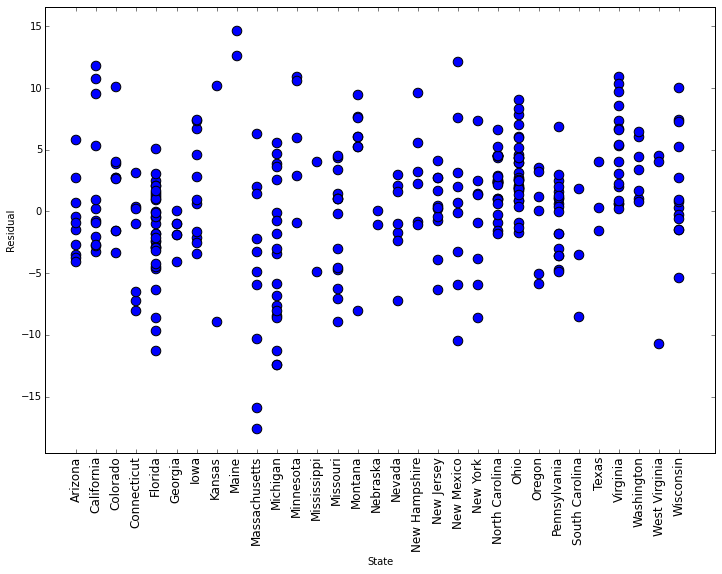

In [142]:
fig, axes = plt.subplots(figsize=(12,8), subplot_kw={"ylabel" : "Residual",
                                                     "xlabel" : "State"})
i = 0
for state, group in state_resid_group:
    x = [i] * len(group)
    axes.scatter(x, group["resid"], s=91)
    i += 1
states = m_regression_data.State.unique()
states.sort()
#axes.xaxis.get_major_locator().set_params(nbins=len(states))
axes.margins(.05, .05)
axes.xaxis.set_ticks(range(31))
axes.xaxis.set_ticklabels(states);
for label in axes.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize('large')

In [143]:
demo_data = demo_data.drop(demo_data.index[demo_data['State'] == 'District of Columbia'])
demo_data.reset_index(drop=True, inplace=True);

In [144]:
exog = demo_data[["PVI", "per_hisp", "per_black", "average_income", "educ_coll"]]
exog["const"] = 1

/anaconda/envs/pydata/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [145]:
state_m = m_model.predict(exog)

In [146]:
state_m

array([-15.4217, -21.6313,  -5.0082, -10.561 ,  16.1516,   1.9687,
        10.9842,  14.074 ,   2.0836,  -4.6565,  18.1919, -25.1584,
        15.7641,  -7.8211,   1.3951, -17.1674, -14.4888,  -9.6044,
         6.7223,  17.5189,  18.47  ,   8.243 ,   2.4987,  -8.0447,
        -3.1677, -11.2639, -19.1112,   5.3443,   0.8928,   8.2712,
        10.5977,  19.1728,  -1.8028, -16.6034,  -0.1732, -24.4563,
         6.9845,   4.29  ,  18.3768,  -7.1117, -14.4658, -11.14  ,
        -8.1462, -29.3198,  18.9368,  -0.9413,   7.9092, -12.3842,
         3.4667, -31.8014])

In [147]:
unit_m = (state_m - state_m.min())/(state_m.max() - state_m.min())

In [148]:
unit_m *= 2

In [149]:
m_correction = zip(demo_data.State, unit_m)

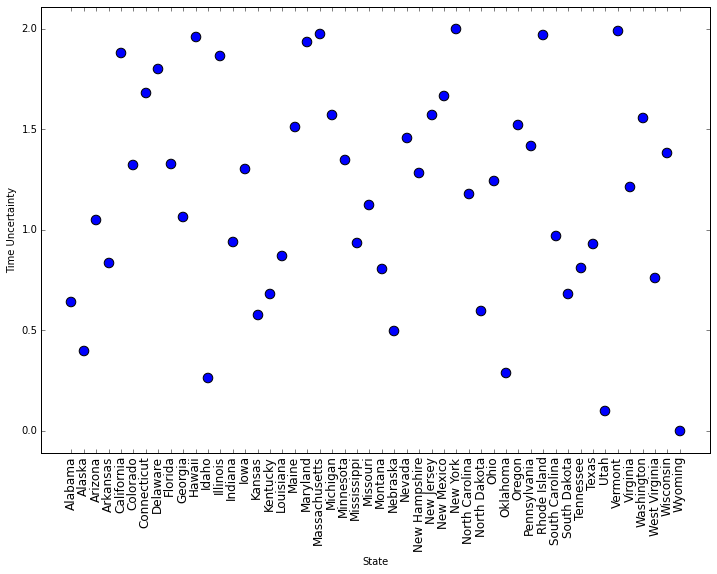

In [150]:
fig, axes = plt.subplots(figsize=(12,8), subplot_kw={"ylabel" : "Time Uncertainty",
                                                     "xlabel" : "State"})

axes.scatter(range(len(unit_m)), unit_m, s=91)

axes.margins(.05, .05)
axes.xaxis.set_ticks(range(len(unit_m)))
axes.xaxis.set_ticklabels(demo_data.State);
for label in axes.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize('large')

In [151]:
m_correction

[('Alabama', 0.64266809431773342),
 ('Alaska', 0.39903009038644149),
 ('Arizona', 1.0512469226033543),
 ('Arkansas', 0.83337963581140184),
 ('California', 1.8814623532136792),
 ('Colorado', 1.3249882703341103),
 ('Connecticut', 1.6787175119991453),
 ('Delaware', 1.7999466163747961),
 ('Florida', 1.3294994223426786),
 ('Georgia', 1.0650469049673186),
 ('Hawaii', 1.9615175450935425),
 ('Idaho', 0.26064183981632583),
 ('Illinois', 1.8662598338917504),
 ('Indiana', 0.94088023761210882),
 ('Iowa', 1.3024853082050096),
 ('Kansas', 0.57417594043008591),
 ('Kentucky', 0.67927212280314431),
 ('Louisiana', 0.87091088640011094),
 ('Maine', 1.5115003017124353),
 ('Maryland', 1.9351096983106113),
 ('Massachusetts', 1.9724278597735232),
 ('Michigan', 1.5711658872393777),
 ('Minnesota', 1.3457855871862934),
 ('Mississippi', 0.93210857837487238),
 ('Missouri', 1.1234597785092251),
 ('Montana', 0.80580138724825001),
 ('Nebraska', 0.49790708186787702),
 ('Nevada', 1.4574319092076853),
 ('New Hampshire',

In [152]:
trends = pandas.DataFrame(trends, columns=["State", "trend"])
m_correction = pandas.DataFrame(m_correction, columns=["State", "m_correction"])

In [153]:
trends = trends.merge(m_correction, on="State")

In [154]:
trends.set_index("State", inplace=True)

In [155]:
trends = trends.product(axis=1)

### Snapshot: Combine Trend Estimates and State Polls

In [156]:
state_polls.name = "poll"
state_polls

State  Pollster                    
AZ     Public Policy Polling (PPP)     -9.168494
       Rasmussen                      -10.209446
CA     Field Poll (CA)                 23.343924
       Public Policy Polling (PPP)     20.999075
       Rasmussen                       22.000000
       SurveyUSA                       22.123414
CO     American Research Group          2.000000
       Public Policy Polling (PPP)      5.469907
       Rasmussen                       -1.573788
CT     Public Policy Polling (PPP)     12.757757
       Quinnipiac                       7.293983
       Rasmussen                        8.000000
FL     American Research Group          5.000000
       Mason-Dixon                     -3.543178
       Public Policy Polling (PPP)      3.125154
       Quinnipiac                       3.075653
       Rasmussen                        0.882884
       Suffolk (NH/MA)                 -0.003377
       SurveyUSA                        4.168952
GA     Insider Advantage         

In [157]:
state_polls = state_polls.reset_index()
state_polls.State = state_polls.State.replace(states_abbrev_dict)

In [158]:
trends.name = "poll"
trends

State
Washington        7.030956
New Hampshire     5.788660
New Jersey        7.095052
Nevada            6.576822
Colorado          5.979155
Connecticut       7.575398
Virginia          5.463930
Massachusetts     8.900798
Rhode Island      8.884297
Hawaii            8.851564
Vermont           8.983443
Maryland          8.732396
Minnesota         6.073006
Illinois          8.421703
North Carolina    3.519400
Georgia           3.184612
West Virginia     2.278010
South Carolina    2.896570
Tennessee         2.423971
Mississippi       2.787112
Wisconsin         7.872436
New Mexico        9.464191
North Dakota      3.392443
Nebraska          2.832664
Ohio              7.059944
Pennsylvania      8.056202
Indiana           5.352802
Iowa              7.410025
Arizona           5.980694
Maine             8.599141
Missouri          6.391523
Michigan          8.938587
Montana           4.584319
Kansas            3.266569
Oregon            8.657667
South Dakota      3.869590
Utah              0.55

In [159]:
trends = trends.reset_index()
trends["Pollster"] = "National"

In [206]:
trends.head()

,State,poll,Pollster
0,Washington,7.030956,National
1,New Hampshire,5.788660,National
2,New Jersey,7.095052,National
3,Nevada,6.576822,National
4,Colorado,5.979155,National


In [161]:
polls = pandas.concat((state_polls, trends))

In [207]:
weights.head(10)

,Pollster,Weight,PIE
0,ABC / Washington Post,0.95,1.41
1,American Research Group,0.65,1.76
2,CBS / New York Times,0.66,1.84
3,Chicago Trib. / MarketShares,1.16,1.13
4,CNN / Opinion Research,0.77,1.59
5,Columbus Dispatch (OH),0.50,6.76
6,EPIC-MRA,0.75,1.65
7,Fairleigh-Dickinson (NJ),0.71,1.72
8,Field Poll (CA),1.33,0.88
9,Fox / Opinion Dynamics,0.79,1.60


In [163]:
natl_weight = pandas.DataFrame([["National", weights.Weight.mean(), weights.PIE.mean()]],
                                columns=["Pollster", "Weight", "PIE"])
weights = pandas.concat((weights, natl_weight)).reset_index(drop=True)

In [164]:
polls = polls.merge(weights, on="Pollster", how="left")

In [165]:
polls = polls.sort("State")

In [166]:
def weighted_mean(group):
    return (group["poll"] * group["Weight"] / group["Weight"].sum()).sum()

In [167]:
group

,resid,State
304,5.224651,Wisconsin
305,7.432851,Wisconsin
306,0.277203,Wisconsin
307,10.002459,Wisconsin
308,0.728450,Wisconsin
309,2.679444,Wisconsin
310,-0.268988,Wisconsin
311,0.890637,Wisconsin
312,7.240347,Wisconsin
313,-0.644929,Wisconsin


In [168]:
results = polls.groupby("State").aggregate(weighted_mean)["poll"]

In [169]:
results

State
Arizona           -5.362448
California        19.966475
Colorado           2.667843
Connecticut        8.936227
Florida            2.170963
Georgia           -8.858592
Hawaii            18.584803
Illinois          15.477867
Indiana           -7.220115
Iowa               2.111760
Kansas            -9.708495
Maine             12.353797
Maryland          16.384295
Massachusetts     14.174631
Michigan           8.393170
Minnesota          6.749915
Mississippi       -8.346582
Missouri          -2.152930
Montana           -7.188138
Nebraska          -8.789196
Nevada             5.093130
New Hampshire     -1.547056
New Jersey        10.641219
New Mexico        10.709465
New York          23.473550
North Carolina    -0.466602
North Dakota      -9.287194
Ohio               4.229394
Oregon             8.794742
Pennsylvania       5.502556
Rhode Island      13.236853
South Carolina    -6.464800
South Dakota      -1.423598
Tennessee         -2.630226
Texas             -2.295507
Utah          

In [170]:
results = results.reset_index()
results["obama"] = 0
results["romney"] = 0
results.ix[results["poll"] > 0, ["obama"]] = 1
results.ix[results["poll"] < 0, ["romney"]] = 1

In [171]:
results[["State", "poll"]].to_csv("./data/2012-predicted.csv", index=False)

In [172]:
electoral_votes = pandas.read_csv("./data/electoral_votes.csv")

In [173]:
electoral_votes.sort("State", inplace=True)
electoral_votes.reset_index(drop=True, inplace=True)

In [174]:
results = electoral_votes.merge(results, on="State", how="left")

In [175]:
results = results.set_index("State")
red_states = ["Alabama", "Alaska", "Arkansas", "Idaho", "Kentucky", "Louisiana",
              "Oklahoma", "Wyoming"]
blue_states = ["Delaware", "District of Columbia"]
results.ix[red_states, ["romney"]] = 1
results.ix[red_states, ["obama"]] = 0
results.ix[blue_states, ["obama"]] = 1
results.ix[blue_states, ["romney"]] = 0

In [176]:
results

,Votes,poll,obama,romney
State,,,,
Alabama,9,NaN,0,1
Alaska,3,NaN,0,1
Arizona,11,-5.362448,0,1
Arkansas,6,NaN,0,1
California,55,19.966475,1,0
Colorado,9,2.667843,1,0
Connecticut,7,8.936227,1,0
Delaware,3,NaN,1,0
District of Columbia,3,NaN,1,0


In [177]:
results["Votes"].mul(results["obama"]).sum()

328.0

In [178]:
results["Votes"].mul(results["romney"]).sum()

210.0

In [179]:
results

,Votes,poll,obama,romney
State,,,,
Alabama,9,NaN,0,1
Alaska,3,NaN,0,1
Arizona,11,-5.362448,0,1
Arkansas,6,NaN,0,1
California,55,19.966475,1,0
Colorado,9,2.667843,1,0
Connecticut,7,8.936227,1,0
Delaware,3,NaN,1,0
District of Columbia,3,NaN,1,0


TODO:

Divide undecided voters probabilistically.

Do historical adjustments based on how polls changed in the past conditional on "election environment"

"Error analysis"

# Error Analysis

Polling errors are from sample variance and other ambiguities inherent to polling

Model the Polling error, based on these factors:

* The error is higher in races with fewer polls
* The error is higher in races where the polls disagree with one another.
* The error is higher when there are a larger number of undecided voters.
* The error is higher when the margin between the two candidates is lopsided.
* The error is higher the further one is from Election Day.

We don't have the data to model this but we will guestimate so we can show you the full process.

We need error estimates for each state (local error) and for the generic ballot (national error). These are combined to get the total error for each state.

The national error creates correlation between the state results.

$$
LocalError = \sqrt{TotalError^{2} + NationalError^{2}}
$$



Source: http://fivethirtyeight.blogs.nytimes.com/methodology/?_r=0

In [180]:
national_margin_of_error = 3.0
local_margin_of_error = Series(np.array([3.0] * 8), index=tossup)
local_margin_of_error

Colorado         3
Florida          3
Iowa             3
New Hampshire    3
Nevada           3
Ohio             3
Virginia         3
Wisconsin        3
dtype: float64

In [181]:
np.random.seed(1)
N = 10000
local_error_sim = DataFrame(np.random.randn(N, len(tossup)), columns=tossup).multiply(local_margin_of_error)
national_error_sim = Series(np.random.randn(N) * national_margin_of_error)

In [182]:
# local error deviations
local_error_sim.iloc[:10,]

,Colorado,Florida,Iowa,New Hampshire,Nevada,Ohio,Virginia,Wisconsin
0,4.873036,-1.835269,-1.584515,-3.218906,2.596223,-6.904616,5.234435,-2.283621
1,0.957117,-0.748111,4.386324,-6.180422,-0.967252,-1.152163,3.401308,-3.299674
2,-0.517285,-2.633575,0.126641,1.748446,-3.301858,3.434171,2.704772,1.507483
3,2.702568,-2.051184,-0.368671,-2.807308,-0.803664,1.591066,-2.074982,-1.190261
4,-2.061518,-2.535617,-2.013738,-0.037994,-3.351931,0.703247,4.979407,2.226132
5,-0.575507,-2.662887,-2.241475,5.077364,0.152423,-1.910987,0.572746,6.300765
6,0.360477,1.851609,0.900511,-1.056750,-3.427555,-1.048028,-0.626683,1.759870
7,2.516950,2.793306,0.856762,2.655423,-2.263194,3.758604,1.538789,-0.894279
8,1.465554,-0.226715,3.394888,4.559450,6.556726,-4.189489,-4.332341,-1.513398
9,0.480111,2.628507,0.946905,-6.066604,-0.918612,2.483924,0.690284,2.286034


In [183]:
# total error deviations
total_error_sim = local_error_sim.add(national_error_sim, axis='rows')
total_error_sim.iloc[:10,]

,Colorado,Florida,Iowa,New Hampshire,Nevada,Ohio,Virginia,Wisconsin
0,8.710056,2.001751,2.252505,0.618114,6.433243,-3.067596,9.071456,1.553400
1,0.472249,-1.232979,3.901456,-6.665290,-1.452120,-1.637031,2.916440,-3.784542
2,-2.403524,-4.519815,-1.759598,-0.137794,-5.188097,1.547932,0.818533,-0.378756
3,-1.191917,-5.945668,-4.263155,-6.701793,-4.698149,-2.303418,-5.969467,-5.084745
4,1.793951,1.319852,1.841730,3.817475,0.503538,4.558716,8.834875,6.081601
5,-2.572048,-4.659428,-4.238016,3.080822,-1.844118,-3.907528,-1.423795,4.304224
6,-0.158740,1.332393,0.381295,-1.575966,-3.946771,-1.567245,-1.145899,1.240653
7,2.745183,3.021539,1.084994,2.883656,-2.034961,3.986837,1.767022,-0.666046
8,1.963082,0.270812,3.892416,5.056978,7.054254,-3.691961,-3.834814,-1.015870
9,-3.459845,-1.311450,-2.993052,-10.006560,-4.858569,-1.456033,-3.249672,-1.653923


In [184]:
# to that we add the model predictions for each state
simulated_poll_predictions = total_error_sim.add(results.ix[tossup, 'poll'])
simulated_poll_predictions.iloc[:10,]

,Colorado,Florida,Iowa,New Hampshire,Nevada,Ohio,Virginia,Wisconsin
0,11.377900,4.172714,4.364265,-0.928942,11.526373,1.161799,11.491700,6.181143
1,3.140093,0.937984,6.013216,-8.212346,3.641010,2.592363,5.336685,0.843202
2,0.264319,-2.348852,0.352162,-1.684850,-0.094967,5.777326,3.238777,4.248987
3,1.475926,-3.774705,-2.151395,-8.248849,0.394981,1.925976,-3.549223,-0.457002
4,4.461794,3.490815,3.953491,2.270419,5.596668,8.788110,11.255119,10.709345
5,0.095795,-2.488465,-2.126256,1.533766,3.249012,0.321866,0.996449,8.931968
6,2.509104,3.503356,2.493055,-3.123022,1.146359,2.662150,1.274345,5.868397
7,5.413026,5.192502,3.196755,1.336600,3.058169,8.216231,4.187266,3.961697
8,4.630925,2.441775,6.004176,3.509922,12.147384,0.537433,-1.414570,3.611874
9,-0.792002,0.859513,-0.881291,-11.553616,0.234561,2.773362,-0.829428,2.973821


In [185]:
simulated_poll_predictions.corr()

,Colorado,Florida,Iowa,New Hampshire,Nevada,Ohio,Virginia,Wisconsin
Colorado,1.000000,0.495928,0.493505,0.503438,0.500832,0.505176,0.499251,0.502516
Florida,0.495928,1.000000,0.504859,0.484577,0.495763,0.494672,0.493993,0.501656
Iowa,0.493505,0.504859,1.000000,0.493213,0.489625,0.502977,0.496665,0.505508
New Hampshire,0.503438,0.484577,0.493213,1.000000,0.505407,0.500251,0.505616,0.506102
Nevada,0.500832,0.495763,0.489625,0.505407,1.000000,0.497530,0.491802,0.504529
Ohio,0.505176,0.494672,0.502977,0.500251,0.497530,1.000000,0.491498,0.493094
Virginia,0.499251,0.493993,0.496665,0.505616,0.491802,0.491498,1.000000,0.499111
Wisconsin,0.502516,0.501656,0.505508,0.506102,0.504529,0.493094,0.499111,1.000000


In [186]:
wins = DataFrame([sum(simulated_poll_predictions[s] > 0) / float(N) for s in tossup], index=tossup, columns=["DemWinPct"])
wins['RepWinPct'] = 1 - wins['DemWinPct']
wins

,DemWinPct,RepWinPct
Colorado,0.7453,0.2547
Florida,0.6937,0.3063
Iowa,0.6937,0.3063
New Hampshire,0.3541,0.6459
Nevada,0.8871,0.1129
Ohio,0.8373,0.1627
Virginia,0.7235,0.2765
Wisconsin,0.8717,0.1283


In [187]:
bins = np.arange(-10, 10, 0.2)
histograms = {s: np.histogram(simulated_poll_predictions[s], bins=bins, density=True)[0] for s in tossup}

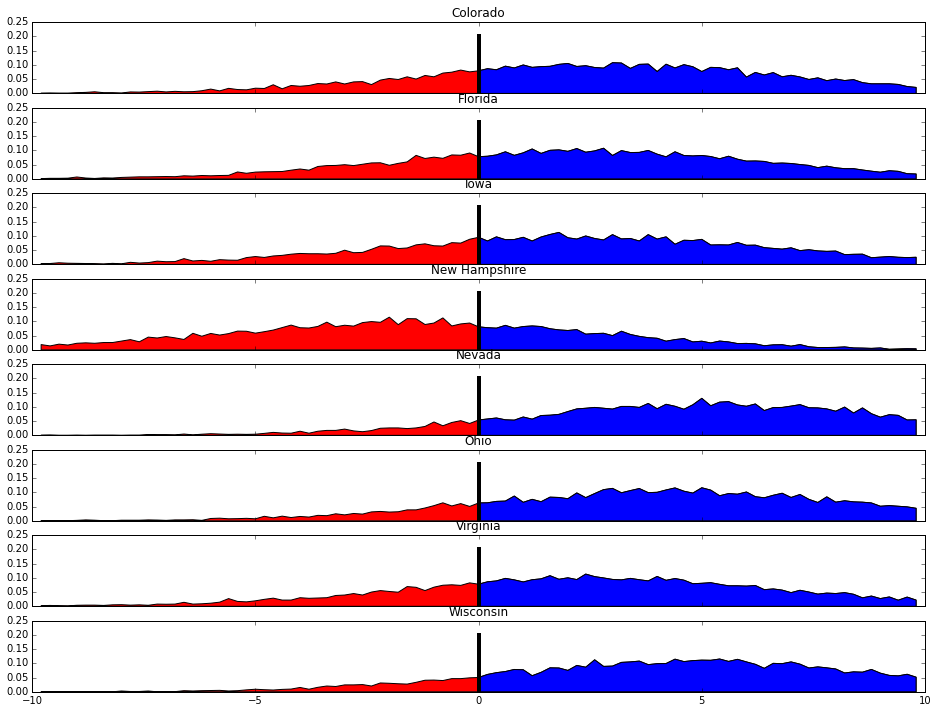

In [188]:
fig, axes = plt.subplots(len(tossup), 1, sharex=True, figsize=(16,  12))

for state, ax in zip(tossup, axes):
    ax.fill_between(bins[1:], 0, histograms[state], facecolor='red')
    ax.fill_between(bins[50:], 0, histograms[state][49:], facecolor='blue')
    ax.set_title(state)
    ax.plot([0.0, 0.0], [0, 0.2], color='k', linewidth=4)  

In [189]:
# electorial votes for the non-tossup states
solid = set(results.index).difference(tossup)
solid_obama = results["Votes"].mul(results["obama"])[solid].sum()
solid_romney = results["Votes"].mul(results["romney"])[solid].sum()

print "Solid Obama Electorial College Votes", solid_obama
print "Solid Romney Electorial College Votes", solid_romney

Solid Obama Electorial College Votes 237.0
Solid Romney Electorial College Votes 206.0


In [190]:
# electorial college votes for the tossup states, from the simulation
tossup_electoral_votes = electoral_votes.set_index('State').ix[tossup, 'Votes']

obama_simulated_electorial_college = (simulated_poll_predictions > 0).multiply(tossup_electoral_votes)
obama_simulated_electorial_college['Solid States'] = solid_obama
obama_simulated_electorial_college['Total'] = obama_simulated_electorial_college.sum(axis=1)

romney_simulated_electorial_college = (simulated_poll_predictions < 0).multiply(tossup_electoral_votes)
romney_simulated_electorial_college['Solid States'] = solid_romney
romney_simulated_electorial_college['Total'] = romney_simulated_electorial_college.sum(axis=1)

In [191]:
obama_simulated_electorial_college.iloc[:10,]

,Colorado,Florida,Iowa,New Hampshire,Nevada,Ohio,Virginia,Wisconsin,Solid States,Total
0,9,29,6,0,6,18,13,10,237,328
1,9,29,6,0,6,18,13,10,237,328
2,9,0,6,0,0,18,13,10,237,293
3,9,0,0,0,6,18,0,0,237,270
4,9,29,6,4,6,18,13,10,237,332
5,9,0,0,4,6,18,13,10,237,297
6,9,29,6,0,6,18,13,10,237,328
7,9,29,6,4,6,18,13,10,237,332
8,9,29,6,4,6,18,0,10,237,319
9,0,29,0,0,6,18,0,10,237,300


In [192]:
romney_simulated_electorial_college.iloc[:10,]

,Colorado,Florida,Iowa,New Hampshire,Nevada,Ohio,Virginia,Wisconsin,Solid States,Total
0,0,0,0,4,0,0,0,0,206,210
1,0,0,0,4,0,0,0,0,206,210
2,0,29,0,4,6,0,0,0,206,245
3,0,29,6,4,0,0,13,10,206,268
4,0,0,0,0,0,0,0,0,206,206
5,0,29,6,0,0,0,0,0,206,241
6,0,0,0,4,0,0,0,0,206,210
7,0,0,0,0,0,0,0,0,206,206
8,0,0,0,0,0,0,13,0,206,219
9,9,0,6,4,0,0,13,0,206,238


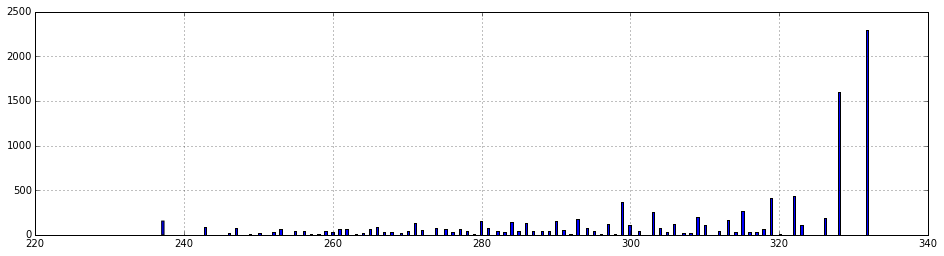

In [193]:
obama_simulated_electorial_college['Total'].hist(bins=300, figsize=(16, 4))

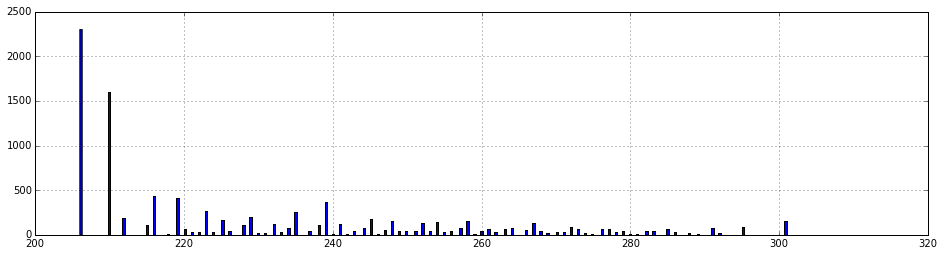

In [194]:
romney_simulated_electorial_college['Total'].hist(bins=300, figsize=(16, 4))

In [195]:
sum(obama_simulated_electorial_college['Total'] > romney_simulated_electorial_college['Total']) / float(N)

0.89610000000000001